# Answering business Questions Using SQL

This project aims to explore a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables as following:
employee, customer, invoice, invoice_line, playlist, playlist_track, track, media_type, genre, artist, album.

The Chinook database is provided as a SQLite database file called chinook.db

### Import Libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

db = 'chinook.db'

### Helper Functions

In [2]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    

In [3]:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None # tell sqlite to autocommit any changes
        conn.execute(c)

In [4]:
def show_tables():
    q = '''SELECT name, type
            FROM sqlite_master
            WHERE type in ("table", "view");'''
    return run_query(q)

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Situation 1:  Selecting New Albums to Purchase
The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

Artist_Name (Genre)
- Regal (Hip-Hop)
- Red Tone (Punk)
- Meteor and the Girls (Pop)
- Slim Jim Bites (Blues)

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [14]:
tracks_sale_by_genre = '''
    WITH usa_track_sale AS
    (SELECT il.*
     from invoice_line il
     INNER JOIN invoice i
     on il.invoice_id = i.invoice_id
     INNER JOIN customer c
     ON c.customer_id = i.customer_id
     WHERE c.country = 'USA'
    )
    SELECT g.name Genre,
           COUNT(uts.invoice_line_id) Tracks_sold,
           CAST(COUNT(uts.invoice_line_id) AS FLOAT) / 
           (SELECT COUNT(*) FROM usa_track_sale) * 100 Percentage_sold
    FROM usa_track_sale uts
    INNER JOIN track t
    on uts.track_id = t.track_id
    INNER JOIN genre g
    ON t.genre_id = g.genre_id
    GROUP BY 1
    ORDER by 2 DESC
    limit 10;
    
'''

run_query(tracks_sale_by_genre)

,Genre,Tracks_sold,Percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


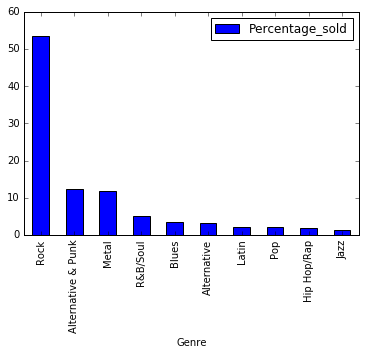

In [15]:
genre_sales_usa = run_query(tracks_sale_by_genre)
genre_sales_usa.plot.bar(x='Genre', y='Percentage_sold')

Based on the above analysis of track sales across different genres in USA, I would recommend make purchases of the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

Since these artists are not in the best selling genre - Rock, I would recommend to be on the look out for artists in the Rock genre. 

### Situation 2: Analyzing Employee Sales Performance
 
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [7]:
sales_by_support_agent = '''
    WITH sales_by_support AS
    (SELECT c.customer_id, 
            c.support_rep_id,
            sum(i.total) total_sales
     FROM customer c
     inner join invoice i
     on c.customer_id = i.customer_id
     GROUP BY 2
     )
     SELECT e.first_name || ' ' || e.last_name support_name,
            e.hire_date, 
            sbs.total_sales
     FROM employee e
     inner join sales_by_support sbs
     on sbs.support_rep_id = e.employee_id
     ORDER BY 3 DESC

'''
run_query(sales_by_support_agent)

,support_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


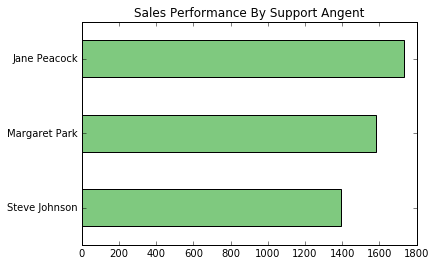

In [12]:
sales_performance = run_query(sales_by_support_agent)
sales_performance.set_index('support_name', drop=True, inplace=True)
sales_performance.sort_values('total_sales', inplace=True)
sales_performance.plot.barh(legend=False,
                           title='Sales Performance By Support Angent',
                           colormap=plt.cm.Accent
                           )
plt.ylabel('')
plt.show()

As can be seen from the above, the difference in sales between top support agent and bottom one could mostly attribute to their hiring dates difference.

In [4]:
from datetime import date
q = '''select e.title, e.hire_date, e.hire_date - '2018-04-10 00:00:00'
        from employee e
        inner join customer c
        on e.employee_id = c.support_rep_id
        limit 5
    '''
run_query(q)

,title,hire_date,e.hire_date - '2018-04-10 00:00:00'
0,Sales Support Agent,2017-04-01 00:00:00,-1
1,Sales Support Agent,2017-04-01 00:00:00,-1
2,Sales Support Agent,2017-04-01 00:00:00,-1
3,Sales Support Agent,2017-04-01 00:00:00,-1
4,Sales Support Agent,2017-04-01 00:00:00,-1


### Situation 3:  Analyzing Sales by Country

Your next task is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [15]:
testq = '''
    SELECT c.country country,
             COUNT(*) total_num_sales,
             SUM(total) total_sales
      from invoice i
      inner join customer c
      on c.customer_id = i.customer_id
      group by country
      order by total_sales desc
'''
run_query(testq)

,country,total_num_sales,total_sales
0,USA,131,1040.49
1,Canada,76,535.59
2,Brazil,61,427.68
3,France,50,389.07
4,Germany,41,334.62
5,Czech Republic,30,273.24
6,United Kingdom,28,245.52
7,Portugal,29,185.13
8,India,21,183.15
9,Ireland,13,114.84


In [5]:
c = '''
CREATE VIEW total_num_customers AS
    SELECT country, 
           COUNT(*) total_customers
     FROM customer
     group by country
'''
run_command(c)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [7]:
sales_country = '''
    WITH country_customers_sales AS
    (SELECT 
        CASE
            WHEN (
                SELECT COUNT(*)
                FROM customer
                WHERE country = c.country
                ) = 1 THEN 'Other'
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
     FROM invoice_line il
     INNER JOIN invoice i
     ON il.invoice_id = i.invoice_id
     INNER JOIN customer c
     ON i.customer_id = c.customer_id
     )
     
    SELECT 
        country,
        total_num_customers,
        total_sales,
        avg_sales_per_customer,
        avg_order_value          
    FROM (
          SELECT 
            country,
            COUNT(DISTINCT customer_id) total_num_customers,
            SUM(unit_price) total_sales,   
            SUM(unit_price) / COUNT(DISTINCT customer_id) avg_sales_per_customer,
            SUM(unit_price) / COUNT(DISTINCT invoice_id) avg_order_value,
            CASE 
                WHEN country = 'Other' THEN 1
                ELSE 0
            END AS sort
         FROM country_customers_sales
         GROUP BY country
         ORDER BY sort ASC, total_sales DESC
        )
           
'''
run_query(sales_country)

,country,total_num_customers,total_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


### Situation 4: Visualizing Sales by Country

Create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

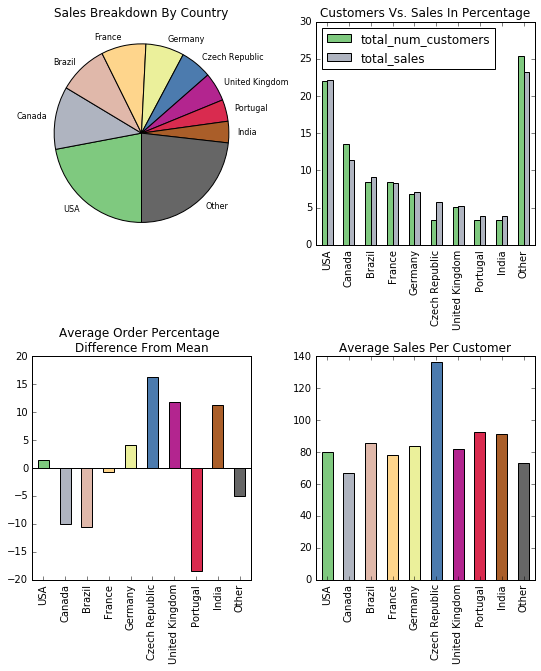

In [41]:
country_metrics = run_query(sales_country)
country_metrics.set_index('country', drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales = country_metrics['total_sales'].copy().rename('')
sales.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown By Country',
    fontsize=8,
    colormap=plt.cm.Accent
    )

# top right
cs_cols = ['total_num_customers', 'total_sales']
customers_sales = country_metrics[cs_cols].copy()
customers_sales.index.name = ''
#print(customers_sales)

for c in cs_cols:
    customers_sales[c] = customers_sales[c] / customers_sales[c].sum() * 100
#print(customers_sales)
customers_sales.plot.bar(
    ax=ax2,
    color=colors,
    title='Customers Vs. Sales In Percentage'
    )

# bottom left
orders = country_metrics['avg_order_value'].copy()
orders.index.name = ''
diff_from_avg_orders = orders * 100 / orders.mean() - 100
diff_from_avg_orders.plot.bar(
    ax=ax3,
    color=colors,
    title='Average Order Percentage \nDifference From Mean'
    )
ax3.axhline(0, color='k')
ax3.tick_params(top='off', right='off')

# bottom right
sales_per_customer = country_metrics['avg_sales_per_customer'].copy()
sales_per_customer.index.name = ''
sales_per_customer.plot.bar(
    ax=ax4,
    color=colors,
    title='Average Sales Per Customer'
)

plt.show()

Based on the above analysis, there may be opportunities in these countries:
- Czech Republic,
- UK 
- India 

Since the data on these countries is relativly small, be cautious with the new advertising campaigns.  Better run small marketing campaign, collect and analyze data on new customers to make sure that these trends hold for these new customers.

### Situation 5:  Albums vs. Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [13]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Since album purchase is about 18% of all sales, I woundn't recommend management to go forward with new purchasing strategy.  They risk lost of sales of other tracks other than the most popular tracks from each album. 

In [12]:
# original work to be revisited
"""
tracks_vs_albums = '''
    WITH invoice_tracks AS
        (
         SELECT
            i.invoice_id invoice_id,
            il.track_id track_id           
         FROM invoice i
         inner join invoice_line il
         on i.invoice_id = il.invoice_id   
        ),
        
    invoice_albums AS
        (
         SELECT
            DISTINCT t.album_id album_id,
            it.invoice_id invoice_id  
         FROM invoice_tracks it
         inner join track t
         on t.track_id = it.track_id
        ),
        
    SELECT
        album_purchase,
        COUNT(invoice_id) num_of_purchase,
        CAST(COUNT(invoice_id) AS FLOAT) / (
                            SELECT COUNT(*)
                            FROM invoice
                         ) percentage_of_invoice
    FROM
        (
         SELECT
            it.invoice_id invoice_id,
            CASE
                WHEN
                (
                  (
                    SELECT 
                         track_id 
                    FROM invoice_tracks it
                    WHERE it.invoice_id = invoice_id
                    
                    EXCEPT
                    
                    SELECT 
                        track_id 
                    FROM track t
                    inner join invoice_albums ia
                    on ia.album_id = t.album_id
                    WHERE ia.invoice_id = invoice_id
                  ) IS NULL 
                  AND
                  (
                    SELECT 
                        track_id 
                    FROM track t
                    inner join invoice_albums ia
                    on ia.album_id = t.album_id
                    WHERE ia.invoice_id = invoice_id
                    
                    EXCEPT
                    
                    SELECT 
                        track_id 
                    FROM invoice_tracks it
                    WHERE it.invoice_id = invoice_id
                  ) IS NULL
                ) = 'True' THEN 'Yes'
                ELSE 'No'           
            END AS 'album_purchase'
         FROM invoice_tracks it
        )
    GROUP BY album_purchase
    
    
'''
run_query(tracks_vs_albums)
"""

"\ntracks_vs_albums = '''\n    WITH invoice_tracks AS\n        (\n         SELECT\n            i.invoice_id invoice_id,\n            il.track_id track_id           \n         FROM invoice i\n         inner join invoice_line il\n         on i.invoice_id = il.invoice_id   \n        ),\n        \n    invoice_albums AS\n        (\n         SELECT\n            DISTINCT t.album_id album_id,\n            it.invoice_id invoice_id  \n         FROM invoice_tracks it\n         inner join track t\n         on t.track_id = it.track_id\n        ),\n        \n    SELECT\n        album_purchase,\n        COUNT(invoice_id) num_of_purchase,\n        CAST(COUNT(invoice_id) AS FLOAT) / (\n                            SELECT COUNT(*)\n                            FROM invoice\n                         ) percentage_of_invoice\n    FROM\n        (\n         SELECT\n            it.invoice_id invoice_id,\n            CASE\n                WHEN\n                (\n                  (\n                    SELECT \